In [1]:
import os , sys
from dask import compute, persist
from dask.distributed import Client, progress
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
from sklearn.neural_network import MLPRegressor
from dask_ml.preprocessing import StandardScaler,LabelEncoder
from dask_ml.model_selection import HyperbandSearchCV ,RandomizedSearchCV,KFold
import numpy as np
import pickle
import dask.array as da
from sklearn.metrics import classification_report,matthews_corrcoef
from sklearn.linear_model import SGDRegressor
from scipy.stats import uniform, loguniform 
from dask_ml.xgboost import XGBRegressor
import pickle
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,accuracy_score

# import xgboost.XGBRFClassifier as xRFC

In [2]:
import dask
print (f'Dask version {dask.__version__}')

Dask version 2.20.0


In [3]:
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='16GB')

In [4]:
client

Client Scheduler: inproc://10.228.0.65/35541/1 Dashboard: http://10.228.0.65:8787/status,Cluster Workers: 1 Cores: 4 Memory: 16.00 GB


In [5]:
PDB_BM5 = [
'1EXB','1JTD','1M27','1RKE','2A1A','2GAF','2GTP','2VXT','2W9E',
'2X9A','2YVJ','3A4S','3AAA','BAAD','3AAD','3BIW','3BX7',
'3DAW','3EO1','3EOA','3F1P','3FN1','3G6D','3H11',
'3H2V','3HI6','3HMX','3K75','3L5W','3L89','3LVK','3MXW',
'BP57','CP57','3P57','3PC8','3R9A','3RVW','3S9D','3SZK',
'3V6Z','3VLB','4DN4','4FQI','4FZA','4G6J','4G6M','4GAM',
'4GXU','4H03','4HX3','4IZ7','4JCV','4LW4','4M76'
]

In [149]:
def load_data_sets():
    all_balanced_data = dd.read_csv("../data/Clean_dataframe_balanced_all_data_ccharppi_4_march_2020_complete.csv")
    all_balanced_data = all_balanced_data.drop("class_q",axis=1)
    all_balanced_data = all_balanced_data.set_index('Conf')
    
#     print (all_balanced_data.shape)
#     all_balanced_data.loc["Z_1JTG_1136_M.pdb","DDG_V"]  = all_balanced_data["DDG_V"].mean()
    
    all_unbalanced_data = dd.read_csv("../data/Clean_dataframe_unbalanced_all_data_ccharppi_4_march_2020_complete.csv",dtype={'class_q': 'object'})
    all_unbalanced_data = all_unbalanced_data.drop("class_q",axis=1)
    all_unbalanced_data = all_unbalanced_data.set_index('Conf')
#     all_unbalanced_data.loc["Z_1JTG_1136_M.pdb","DDG_V"]  = all_balanced_data["DDG_V"].mean()


    Scorers_balanced_data = dd.read_csv("../data/Clean_dataframe_balanced_scorers_set_march_22_2021.csv")
    Scorers_balanced_data = Scorers_balanced_data.set_index('Conf')
    Scorers_balanced_data = Scorers_balanced_data.dropna()

    Scorers_unbalanced_data = dd.read_csv("../data/Clean_dataframe_unbalanced_scorers_set_march_22_2021.csv")
    Scorers_unbalanced_data = Scorers_unbalanced_data.set_index('Conf')
    Scorers_unbalanced_data = Scorers_unbalanced_data.dropna()

    X_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]
    y_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]["DQ_val"]

#     y_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')

            ## data set for less than 5 
    X_val = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]
    y_val = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]["DQ_val"]

#     y_val = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
    #         print (X_test.size,y_test.size)
            ## data set for less than 5 
    X_val_u = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]
    y_val_u = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]["DQ_val"]
#     y_val_u = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')

    
    X_test = Scorers_balanced_data
    y_test = Scorers_balanced_data["binary_label"].astype('bool')
    
    X_test_u = Scorers_unbalanced_data
    y_test_u = Scorers_unbalanced_data["DQ_val"]
#     y_test_u = Scorers_unbalanced_data["binary_label"].astype('bool')

    
    X_test_u = X_test_u.rename(columns={'NIS Polar' :'Nis_Polar',
                                  'Nis Apolar':'Nis_Apolar',
                                  'BSA Apolar':'BSA_Apolar',
                                  'BSA Polar' :'BSA_Polar',
                                'binary_label':'label_binary'
                            })
    X_test= X_test.rename(columns={'NIS Polar' :'Nis_Polar',
                                  'Nis Apolar':'Nis_Apolar',
                                  'BSA Apolar':'BSA_Apolar',
                                  'BSA Polar' :'BSA_Polar',
                                   'binary_label':'label_binary'
                          })
    
#     for x in X_val_u.columns:
#         if x not in X_test.columns:
#             print (x)
    return X_train, y_train , X_val, y_val, X_test, y_test ,X_val_u, y_val_u, X_test_u, y_test_u 

In [150]:
def scaling_data_selected(X_train,X_test,X_test_unbalanced):
#     scaler = MinMaxScaler()
    scaler = StandardScaler()
#     selected_feat = ['AP_DFIRE2','AP_PISA','AP_T1','AP_T2','CP_MJ3h','SIPPER','ELE','VDW','PYDOCK_TOT','AP_dDFIRE']

    selected_feat = ['CONSRANK_val','AP_DFIRE2','num_of_contacs','AP_calRWp','AP_GEOMETRIC',
                     'CP_ELOCAL_CB','ELE','NSC','CP_E3D_CB','CP_RMFCA',
                     'ALIPH','PP','ZRANK','BSA_Apolar','BSA_Polar','AP_PISA','cips_CC']
#     selected_feat = ['CONSRANK_val','AP_GOAP_DF','CP_TD','CP_D1','CP_HLPL',
#                       'DDG_V','CP_MJ3h','PYDOCK_TOT','ELE','CP_SKOIP',
#                       'SIPPER','AP_DFIRE2','AP_dDFIRE','AP_PISA','CP_RMFCA',
# #                      'CP_TB','AP_DARS','CP_BT'
#                      ]
    
#     selected_feat = ['CONSRANK_val','CP_HLPL','CP_MJ3h','DDG_V','CP_RMFCA','AP_GOAP_DF','CP_Qp','CP_TD','CP_SKOIP','CP_TB','CP_TSC','PYDOCK_TOT','SIPPER',
# 'CP_BT','CP_MJ2h','AP_DFIRE2','CP_RMFCEN1','AP_DARS','AP_PISA','BSA_Apolar','CP_BFKV','AP_dDFIRE','CP_RMFCEN2','CP_ZS3DC_MIN',
# 'AP_DDG_U','AP_DDG_W','cips_AlAr','CP_MJPL','CP_SKOb','CP_TEl','CP_TS','PROPNSTS','AP_MPS','CP_D1','FIREDOCK','AlAr','ArAr']

    X_train = X_train[selected_feat]
    X_test = X_test[selected_feat]
    X_test_unbalanced= X_test_unbalanced[selected_feat]


    scaler.fit(X_train)
    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    scaled_test_u = scaler.transform(X_test_unbalanced)
#     pickle.dump(scaler, open("ScalerBM4_regression.pickle.dat", "wb"))

    return scaled_train,scaled_test,scaled_test_u

In [151]:
def scaling_data(X_train,X_test,X_test_unbalanced):
#     scaler = MinMaxScaler()
    features = ['idx','class_q','pdb1','chains_pdb1','pdb2','chains_pdb2',
                'label_binary','DQ_val','binary_label','identification','labels']
    scaler = StandardScaler()



    for x in features :
        if x in X_train.columns:
            X_train= X_train.drop(x,axis=1)            
    for x in features :
        if x in X_test.columns: 
                X_test = X_test.drop(x,axis=1)
            
    for x in features :
        if x in X_test_unbalanced.columns:
            X_test_unbalanced= X_test_unbalanced.drop(x,axis=1)
            
        
    print(X_train.shape)
    print(X_test.shape)

    scaler.fit(X_train)
    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test[X_train.columns])
    scaled_test_u = scaler.transform(X_test_unbalanced[X_train.columns])
    return scaled_train,scaled_test,scaled_test_u

In [152]:
def regression_report (y_true, y_pred ,name) :
    

    r=r2_score(y_true, y_pred)
    mae=mean_absolute_error(y_true, y_pred)
    mse=mean_squared_error(y_true, y_pred)
    
    print ("R^2:",r)
    print ("MAE:",mae)
    print ("MSE:",mse)
    
#     print ("------------------------------------------")
#     my_results.append((name,r,mae,mse))
    
#     error = y_pred - y_true
#     plt.hist(error, bins = 25)
#     plt.xlabel("Prediction Error [MAE]")
#     _ = plt.ylabel("Count")
#     plt.savefig("../figures/basemodel_error_bin_%s.png"%(name),format="png")
    

#     plt.scatter(y_true, y_pred)
#     plt.xlabel('True Values [MAE]')
#     plt.ylabel('Predictions [MAE]')
#     plt.axis('equal')
#     plt.axis('square')
#     plt.xlim([0,plt.xlim()[1]])
#     plt.ylim([0,plt.ylim()[1]])
#     _ = plt.plot([-100, 100], [-100, 100])
#     plt.savefig("MAE_base_model_%s.png"%(key),format="png")

In [153]:
X_train, y_train , X_val, y_val, X_test, y_test ,X_val_u, y_val_u, X_test_u, y_test_u  = load_data_sets()

In [154]:
params = {
    "hidden_layer_sizes": [

        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3),
    ],
    "activation": ["relu", "logistic", "tanh"],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [16, 32, 64, 128, 256, 512],
}


In [155]:
estimator = MLPRegressor()

In [156]:
X_train

,AA,AA_sqrt,AAl,AAl_sqrt,AAr,AAr_sqrt,ALIPH,AP_ACE,AP_DARS,AP_DCOMPLEX,AP_DDG_U,AP_DDG_W,AP_DFIRE2,AP_DOPE,AP_DOPE_HR,AP_GEOMETRIC,AP_GOAP_ALL,AP_GOAP_DF,AP_GOAP_G,AP_MPS,AP_OPUS_PSP,AP_PISA,AP_T1,AP_T2,AP_URS,AP_W1,AP_calRW,AP_calRWp,AP_dDFIRE,AlAl,AlAl_sqrt,AlAr,AlAr_sqrt,ArAr,ArAr_sqrt,BSA,BSA_Apolar,BSA_Polar,CA,CA_sqrt,CAl,CAl_sqrt,CAr,CAr_sqrt,CC,CC_sqrt,CONSRANK_val,CP,CP_BFKV,CP_BL,CP_BT,CP_D1,CP_DDG_U,CP_DDG_W,CP_E3DC_CB,CP_E3DC_MIN,CP_E3D_CB,CP_E3D_MIN,CP_ELOCAL_CB,CP_ELOCAL_MIN,CP_EPAIR_CB,CP_EPAIR_MIN,CP_ES3DC_CB,CP_ES3DC_MIN,CP_GKS,CP_HLPL,CP_MJ1,CP_MJ2,CP_MJ2h,CP_MJ3h,CP_MJPL,CP_MS,CP_MSBM,CP_Qa,CP_Qm,CP_Qp,CP_RMFCA,CP_RMFCEN1,CP_RMFCEN2,CP_RO,CP_SJKG,CP_SKOIP,CP_SKOa,CP_SKOb,CP_TB,CP_TD,CP_TEl,CP_TEs,CP_TS,CP_TSC,CP_VD,CP_Z3DC_CB,CP_Z3DC_MIN,CP_ZLOCAL_CB,CP_ZLOCAL_MIN,CP_ZPAIR_CB,CP_ZPAIR_MIN,CP_ZS3DC_CB,CP_ZS3DC_MIN,CP_sqrt,DDG_V,DESOLV,DOKB,DQ_val,ELE,FIREDOCK,FIREDOCK_AB,FIREDOCK_EI,HBOND,INSIDE,NSC,Nis_Apolar,Nis_Polar,ODA,PA,PA_sqrt,PAl,PAl_sqrt,PAr,PAr_sqrt,PI_PI,PP,PP_sqrt,PROPNSTS,PYDOCK_TOT,SIPPER,VDW,ZRANK,ZRANK2,avg_cips_AA,avg_cips_AAl,avg_cips_AAr,avg_cips_AlAl,avg_cips_AlAr,avg_cips_ArAr,avg_cips_CA,avg_cips_CAl,avg_cips_CAr,avg_cips_CC,avg_cips_CP,avg_cips_PA,avg_cips_PAl,avg_cips_PAr,avg_cips_PP,cips_AA,cips_AAl,cips_AAr,cips_AlAl,cips_AlAr,cips_ArAr,cips_CA,cips_CAl,cips_CC,cips_CP,cips_PA,cips_PAl,cips_PP,idx,label_binary,num_of_contacs
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F_1A2K_1488_I.pdb,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,int64
H_3L5W_3435_I.pdb,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z_CP57_9980_A.pdb,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [157]:
X_train_fs, X_test_fs, X_test_u_fs = scaling_data(X_train, X_test, X_test_u)
X_train_fs, X_val_fs, X_val_u_fs = scaling_data(X_train, X_val, X_val_u)

# X_train_fs, X_test_fs, X_test_u_fs = scaling_data_selected(X_train, X_test, X_test_u)
# X_train_fs, X_val_fs, X_val_u_fs = scaling_data_selected(X_train, X_val, X_val_u)

(Delayed('int-dc27b23a-63f4-49ae-a722-a28e99cf44cf'), 157)
(Delayed('int-98bb6aa1-19bd-4ce1-9d8b-24c1707a22fd'), 168)
(Delayed('int-55d0f2da-ffed-414b-b199-a83f6c305f27'), 157)
(Delayed('int-a36233d7-8ef3-4cc7-8d52-d65e7f5674ab'), 157)


In [158]:
n_examples = 4 * len(X_train_fs)  # 20 passes through dataset for best model
n_params = 8  # sample about 300 parameters

# inputs to hyperband
max_iter = n_params
chunk_size = n_examples // n_params

In [159]:
X_train_fs.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 157 entries, AA to num_of_contacs
dtypes: float64(157)

In [160]:
X_train_fs.describe()

,AA,AA_sqrt,AAl,AAl_sqrt,AAr,AAr_sqrt,ALIPH,AP_ACE,AP_DARS,AP_DCOMPLEX,AP_DDG_U,AP_DDG_W,AP_DFIRE2,AP_DOPE,AP_DOPE_HR,AP_GEOMETRIC,AP_GOAP_ALL,AP_GOAP_DF,AP_GOAP_G,AP_MPS,AP_OPUS_PSP,AP_PISA,AP_T1,AP_T2,AP_URS,AP_W1,AP_calRW,AP_calRWp,AP_dDFIRE,AlAl,AlAl_sqrt,AlAr,AlAr_sqrt,ArAr,ArAr_sqrt,BSA,BSA_Apolar,BSA_Polar,CA,CA_sqrt,CAl,CAl_sqrt,CAr,CAr_sqrt,CC,CC_sqrt,CONSRANK_val,CP,CP_BFKV,CP_BL,CP_BT,CP_D1,CP_DDG_U,CP_DDG_W,CP_E3DC_CB,CP_E3DC_MIN,CP_E3D_CB,CP_E3D_MIN,CP_ELOCAL_CB,CP_ELOCAL_MIN,CP_EPAIR_CB,CP_EPAIR_MIN,CP_ES3DC_CB,CP_ES3DC_MIN,CP_GKS,CP_HLPL,CP_MJ1,CP_MJ2,CP_MJ2h,CP_MJ3h,CP_MJPL,CP_MS,CP_MSBM,CP_Qa,CP_Qm,CP_Qp,CP_RMFCA,CP_RMFCEN1,CP_RMFCEN2,CP_RO,CP_SJKG,CP_SKOIP,CP_SKOa,CP_SKOb,CP_TB,CP_TD,CP_TEl,CP_TEs,CP_TS,CP_TSC,CP_VD,CP_Z3DC_CB,CP_Z3DC_MIN,CP_ZLOCAL_CB,CP_ZLOCAL_MIN,CP_ZPAIR_CB,CP_ZPAIR_MIN,CP_ZS3DC_CB,CP_ZS3DC_MIN,CP_sqrt,DDG_V,DESOLV,DOKB,ELE,FIREDOCK,FIREDOCK_AB,FIREDOCK_EI,HBOND,INSIDE,NSC,Nis_Apolar,Nis_Polar,ODA,PA,PA_sqrt,PAl,PAl_sqrt,PAr,PAr_sqrt,PI_PI,PP,PP_sqrt,PROPNSTS,PYDOCK_TOT,SIPPER,VDW,ZRANK,ZRANK2,avg_cips_AA,avg_cips_AAl,avg_cips_AAr,avg_cips_AlAl,avg_cips_AlAr,avg_cips_ArAr,avg_cips_CA,avg_cips_CAl,avg_cips_CAr,avg_cips_CC,avg_cips_CP,avg_cips_PA,avg_cips_PAl,avg_cips_PAr,avg_cips_PP,cips_AA,cips_AAl,cips_AAr,cips_AlAl,cips_AlAr,cips_ArAr,cips_CA,cips_CAl,cips_CC,cips_CP,cips_PA,cips_PAl,cips_PP,num_of_contacs
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [161]:
X_train_fs = X_train_fs.to_dask_array()


In [162]:
X_train_fs.compute_chunk_sizes()

dask.array<values, shape=(55748, 157), dtype=float64, chunksize=(31885, 157), chunktype=numpy.ndarray>

In [163]:
X_train_fs = X_train_fs.rechunk(chunks=chunk_size)

In [164]:
# X_train_fs

In [165]:
y_train = y_train.to_dask_array()

In [166]:
y_train.compute_chunk_sizes()

dask.array<values, shape=(55748,), dtype=float64, chunksize=(31885,), chunktype=numpy.ndarray>

In [167]:
y_train = y_train.rechunk(chunks=chunk_size)

In [168]:
# y_train

In [169]:
# Create the random search model
rsnn = HyperbandSearchCV(estimator=estimator, parameters=params ,verbose=True,
                         max_iter=max_iter,patience=True,
                         random_state=32,aggressiveness=4)

In [170]:
rsnn.metadata["partial_fit_calls"]

30

In [171]:
np.random.seed(seed = 101) 

rsnn.fit(X_train_fs,y_train)

[CV, bracket=1] creating 4 models


INFO:dask_ml.model_selection:[CV, bracket=1] creating 4 models


[CV, bracket=0] creating 2 models


INFO:dask_ml.model_selection:[CV, bracket=0] creating 2 models


[CV, bracket=1] For training there are between 22299 and 22299 examples in each chunk


INFO:dask_ml.model_selection:[CV, bracket=1] For training there are between 22299 and 22299 examples in each chunk


[CV, bracket=0] For training there are between 22299 and 22299 examples in each chunk


INFO:dask_ml.model_selection:[CV, bracket=0] For training there are between 22299 and 22299 examples in each chunk


[CV, bracket=1] validation score of 0.4548 received after 1 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=1] validation score of 0.4548 received after 1 partial_fit calls


[CV, bracket=0] validation score of 0.5385 received after 1 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.5385 received after 1 partial_fit calls


[CV, bracket=1] validation score of 0.5991 received after 2 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=1] validation score of 0.5991 received after 2 partial_fit calls


[CV, bracket=1] validation score of 0.6376 received after 4 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=1] validation score of 0.6376 received after 4 partial_fit calls


[CV, bracket=0] validation score of 0.6637 received after 3 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.6637 received after 3 partial_fit calls


[CV, bracket=1] validation score of 0.6286 received after 6 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=1] validation score of 0.6286 received after 6 partial_fit calls
INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.6679 received after 5 partial_fit calls
INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.7266 received after 7 partial_fit calls
INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.7156 received after 8 partial_fit calls


HyperbandSearchCV(aggressiveness=4, estimator=MLPRegressor(), max_iter=8,
                  parameters={'activation': ['relu', 'logistic', 'tanh'],
                              'alpha': array([1.00000000e-06, 1.00693863e-06, 1.01392541e-06, 1.02096066e-06,
       1.02804473e-06, 1.03517796e-06, 1.04236067e-06, 1.04959323e-06,
       1.05687597e-06, 1.06420924e-06, 1.07159340e-06, 1.07902879e-06,
       1.08651577e-06, 1.09405471e-06, 1....
       9.01477631e-04, 9.07732653e-04, 9.14031075e-04, 9.20373200e-04,
       9.26759330e-04, 9.33189772e-04, 9.39664831e-04, 9.46184819e-04,
       9.52750047e-04, 9.59360829e-04, 9.66017480e-04, 9.72720319e-04,
       9.79469667e-04, 9.86265846e-04, 9.93109181e-04, 1.00000000e-03]),
                              'batch_size': [16, 32, 64, 128, 256, 512],
                              'hidden_layer_sizes': [(24,), (12, 12),
                                                     (6, 6, 6, 6),
                                                     (4, 4,

In [172]:
print (rsnn.best_params_)

{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_size': 16, 'alpha': 3.2174181506763714e-05, 'activation': 'tanh'}


In [173]:
classifier = rsnn.best_estimator_

In [174]:
y_pred= classifier.predict(X_val_u_fs)

In [175]:
regression_report( y_true=y_val_u ,y_pred= y_pred, name="NNC_val")

R^2: -0.39079943769067826
MAE: 0.07149916063039365
MSE: 0.012644359271081389


In [176]:
y_pred= classifier.predict(X_test_u_fs)

In [177]:
regression_report( y_true=y_test_u ,y_pred= y_pred, name="NNC_test")

R^2: -0.6979067852376706
MAE: 0.14080935659752972
MSE: 0.03211627766209177


In [178]:
estimator = SGDRegressor() 

In [179]:
#### SGD params 
params = { 
    "l1_ratio": uniform(0, 1), 
    "alpha": loguniform(1e-5, 1e-1), 
    "penalty": ["l2", "l1", "elasticnet"], 
    "learning_rate": ["invscaling", "adaptive","optimal"], 
    "power_t": uniform(0, 1), 
    "average": [True, False], 
    "loss":["squared_loss", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"], 
    "epsilon": loguniform(1e-5, 1e-1), 
    "eta0":np.logspace(-6, -3, num=1000)
} 


In [180]:
rsnn = HyperbandSearchCV(estimator=estimator, parameters=params ,verbose=True,
                         max_iter=max_iter,patience=True,
                         random_state=32,aggressiveness=4)

In [181]:
rsnn.metadata["partial_fit_calls"]

30

In [182]:
np.random.seed(seed = 101) 

rsnn.fit(X_train_fs,y_train)

[CV, bracket=1] creating 4 models


INFO:dask_ml.model_selection:[CV, bracket=1] creating 4 models


[CV, bracket=0] creating 2 models


INFO:dask_ml.model_selection:[CV, bracket=0] creating 2 models


[CV, bracket=1] For training there are between 22299 and 22299 examples in each chunk


INFO:dask_ml.model_selection:[CV, bracket=1] For training there are between 22299 and 22299 examples in each chunk


[CV, bracket=0] For training there are between 22299 and 22299 examples in each chunk


INFO:dask_ml.model_selection:[CV, bracket=0] For training there are between 22299 and 22299 examples in each chunk


[CV, bracket=1] validation score of -0.7749 received after 1 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=1] validation score of -0.7749 received after 1 partial_fit calls


[CV, bracket=0] validation score of 0.0996 received after 1 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.0996 received after 1 partial_fit calls


[CV, bracket=1] validation score of -0.5234 received after 2 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=1] validation score of -0.5234 received after 2 partial_fit calls


[CV, bracket=0] validation score of 0.4381 received after 3 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.4381 received after 3 partial_fit calls


[CV, bracket=1] validation score of -0.5656 received after 4 partial_fit calls


INFO:dask_ml.model_selection:[CV, bracket=1] validation score of -0.5656 received after 4 partial_fit calls
INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.5095 received after 5 partial_fit calls
INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.5872 received after 7 partial_fit calls
INFO:dask_ml.model_selection:[CV, bracket=0] validation score of 0.5374 received after 8 partial_fit calls


HyperbandSearchCV(aggressiveness=4, estimator=SGDRegressor(), max_iter=8,
                  parameters={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x140bfedc0>,
                              'average': [True, False],
                              'epsilon': <scipy.stats._distn_infrastructure.rv_frozen object at 0x140bfe400>,
                              'eta0': array([1.00000000e-06, 1.00693863e-06, 1.01392541e-06, 1.02096066e-06,
       1.02804473e-06, 1.03517...
                              'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x173b85700>,
                              'learning_rate': ['invscaling', 'adaptive',
                                                'optimal'],
                              'loss': ['squared_loss', 'huber',
                                       'epsilon_insensitive',
                                       'squared_epsilon_insensitive'],
                              'penalty': ['l2', 'l1', 'elasticnet']

In [183]:
print ( rsnn.best_params_ )

{'alpha': 0.027261959556018345, 'average': False, 'epsilon': 0.0004832278256276128, 'eta0': 0.0007531420165974368, 'l1_ratio': 0.9556565489917677, 'learning_rate': 'invscaling', 'loss': 'squared_epsilon_insensitive', 'penalty': 'elasticnet', 'power_t': 0.35360111371492264}


In [184]:
classifier = rsnn.best_estimator_

In [185]:
y_pred= classifier.predict(X_val_u_fs)

In [186]:
regression_report( y_true=y_val_u ,y_pred= y_pred, name="SGD_val")

R^2: -0.5586981283986923
MAE: 0.09160757039828543
MSE: 0.014170798892010013


In [187]:
y_pred= classifier.predict(X_test_u_fs)

In [188]:
regression_report( y_true=y_test_u ,y_pred= y_pred, name="SGD_test")

R^2: -3.0660920062759365
MAE: 0.20437831241104834
MSE: 0.07691101832477233


In [189]:
xgb = XGBRegressor()

In [190]:
# params = { 
# "learning_rate" :[0.0001, 0.001, 0.01, 0.1], 
#  "n_estimators":np.linspace(start = 100, stop = 1000, num = 5),
# #  "max_depth":np.linspace(1, 11, num = 10),
# #  "min_child_weight": np.linspace(1, 11, num = 10),
# #  "gamma":[0,2,4,6,8],
# #  "subsample":np.linspace(0,1,num=10),
# #  "colsample_bytree":np.linspace(0,1,num=10),
#  "objective": ['binary:logistic','binary:logitraw','binary:hinge']
# }


In [191]:
# label_encoded_y = LabelEncoder().fit_transform(y_train)


In [192]:
# rsnn.metadata["partial_fit_calls"]

In [193]:
np.random.seed(seed = 101) 
xgb.fit(X_train_fs,y_train)
# rsnn.fit(X_train_fs,y_train,classes=[True,False])
# random_S.fit(X_train_fs.compute(),y_train.compute())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [194]:
y_pred= xgb.predict(X_test_u_fs.to_dask_array())

In [195]:
regression_report( y_true=y_test_u ,y_pred= y_pred.compute(),name="xgb_test")

R^2: -1.7982637767381169
MAE: 0.19446125250697402
MSE: 0.052929770472008024


In [196]:
y_pred= xgb.predict(X_val_u_fs.to_dask_array())

In [197]:
regression_report( y_true=y_val_u ,y_pred= y_pred.compute(),name="xgb_val")

R^2: 0.04674833700157932
MAE: 0.0587695473424361
MSE: 0.008666423192348562


In [198]:
# xgb = XGBClassifier()
features = ['idx','label_binary','DQ_val']


importances  = []
for x,y in zip( xgb.feature_importances_, X_train.drop(features,axis=1).columns) :
    importances.append((y,x)) 
# X_train.columns

In [199]:
# for col in X_train.drop(features,axis=1).columns:
#     print (col)
# # X_train.drop(features,axis=1)

In [200]:
import pandas as pd 
df_importances = pd.DataFrame(importances)

# np.random.seed(seed = 101) 

# # rsnn = HyperbandSearchCV(estimator=xgb, parameters=params ,verbose=True,
# #                          max_iter=max_iter,patience=True,
# #                          random_state=32,aggressiveness=4)
# # kfold = KFold(n_splits=10, shuffle=True, random_state=101)

# random_S = RandomizedSearchCV(estimator = xgb,
#                               param_distributions = params,
#                               scoring="neg_log_loss",
# #                               cv = kfold,
#                               random_state=101, 
#                               n_jobs = -1)

In [201]:
df_importances.sort_values(by=1,ascending=False, inplace =True)
# type(label_encoded_y)

In [202]:
df_importances[df_importances[1]>0.005][0].to_list()
# random_S.fit(X_train_fs,y_train)


['CONSRANK_val',
 'AP_DFIRE2',
 'num_of_contacs',
 'AP_calRWp',
 'AP_GEOMETRIC',
 'CP_ELOCAL_CB',
 'ELE',
 'NSC',
 'CP_E3D_CB',
 'CP_RMFCA',
 'ALIPH',
 'PP',
 'ZRANK',
 'BSA_Apolar',
 'BSA_Polar',
 'AP_PISA',
 'cips_CC',
 'AP_calRW',
 'DESOLV',
 'AP_OPUS_PSP',
 'cips_ArAr',
 'CP_MJPL',
 'CP_ELOCAL_MIN',
 'CP_TSC',
 'Nis_Polar',
 'cips_PP',
 'CP_Qa',
 'cips_AA',
 'cips_AlAl',
 'DDG_V',
 'AP_dDFIRE',
 'CP_RMFCEN2',
 'Nis_Apolar',
 'avg_cips_AlAl',
 'CP_TS',
 'CP_Z3DC_CB',
 'ODA',
 'avg_cips_CAr',
 'CP_ZPAIR_MIN',
 'avg_cips_PAr',
 'CP_D1',
 'cips_CA',
 'CP_EPAIR_CB',
 'CP_MS',
 'AP_T2',
 'cips_AlAr',
 'AP_DOPE',
 'INSIDE',
 'CP_ZS3DC_CB',
 'AlAl',
 'CP_SKOIP',
 'AA']

In [203]:
# print( random_S.best_estimator_ ) 

In [204]:
# np.random.seed(seed = 101) 
# # xgb.fit(X_train_fs,y_train)
# # rsnn.fit(X_train_fs,y_train,classes=[True,False])
# # random_S.fit(X_train_fs,y_train)
# for x in  ['reg:logistic','reg:squarederror','reg:squaredlogerror','reg:pseudohubererror','reg:gamma']:
#     print(x)
#     xgb = XGBRegressor(objective=x,n_estimators=100)
#     xgb.fit(X_train_fs,y_train)
#     y_pred= xgb.predict(X_val_u_fs.to_dask_array())
#     regression_report( y_true=y_val_u ,y_pred= y_pred.compute(),name=x)
#     print ("Test")
#     y_pred= xgb.predict(X_test_u_fs.to_dask_array())
#     regression_report( y_true=y_test_u ,y_pred= y_pred.compute(),name=x)
#     print ()
    


In [205]:
# np.random.seed(seed = 101) 
# # xgb.fit(X_train_fs,y_train)
# # rsnn.fit(X_train_fs,y_train,classes=[True,False])
# # random_S.fit(X_train_fs,y_train)
# for x in np.linspace(start = 100, stop = 1000, num = 3) :
#     print(x)
#     xgb = XGBRegressor(objective='reg:squaredlogerror', n_estimators= int(x) )
#     xgb.fit(X_train_fs,y_train)
#     y_pred= xgb.predict(X_val_u_fs.to_dask_array())
#     regression_report( y_true=y_val_u ,y_pred= y_pred.compute(),name=x)
#     print ("Test")
#     y_pred= xgb.predict(X_test_u_fs.to_dask_array())
#     regression_report( y_true=y_test_u ,y_pred= y_pred.compute(),name=x)
#     print ()


In [206]:
# np.random.seed(seed = 101) 
# # xgb.fit(X_train_fs,y_train)
# # rsnn.fit(X_train_fs,y_train,classes=[True,False])
# # random_S.fit(X_train_fs,y_train)
# learning_rate = [0.00003,0.00001,0.0003,0.0001 ,0.003,0.001]
# for x in  learning_rate:
#     print (x)
#     xgb = XGBRegressor(objective='reg:squaredlogerror',n_estimators=100,learning_rate=x)
#     xgb.fit(X_train_fs,y_train)
#     y_pred= xgb.predict(X_val_u_fs.to_dask_array())
#     regression_report( y_true=y_val_u ,y_pred= y_pred.compute(),name=x)
#     print ()

In [207]:
# np.random.seed(seed = 101) 
# # xgb.fit(X_train_fs,y_train)
# # rsnn.fit(X_train_fs,y_train,classes=[True,False])
# # random_S.fit(X_train_fs,y_train)
# # learning_rate = [0.00003,0.00001,0.0003,0.0001 ,0.003,0.001]
# for x in  np.linspace(start = 0.003, stop = 0.009, num = 20):
#     print (x)
#     xgb = XGBRegressor(objective='reg:squaredlogerror',eval_metric="rmse",n_estimators=100,learning_rate=x)
#     xgb.fit(X_train_fs,y_train)
#     print ("Validation")
#     y_pred= xgb.predict(X_val_u_fs.to_dask_array())
#     regression_report( y_true=y_val_u ,y_pred= y_pred.compute(),name=x)
#     print ("Test")
#     y_pred= xgb.predict(X_test_u_fs.to_dask_array())
#     regression_report( y_true=y_test_u ,y_pred= y_pred.compute(),name=x)
#     print ()

In [208]:
# for x in  ['rmse','rmsle','mae','mape','logloss']:
#     print (x)
#     xgb = XGBRegressor(objective='reg:squarederror',n_estimators=100,eval_metric=x)
#     xgb.fit(X_train_fs,y_train)
#     print ("Validation")
#     y_pred= xgb.predict(X_val_u_fs.to_dask_array())
#     regression_report( y_true=y_val_u ,y_pred= y_pred.compute(),name=x)
#     print ("Test")
#     y_pred= xgb.predict(X_test_u_fs.to_dask_array())
#     regression_report( y_true=y_test_u ,y_pred= y_pred.compute(),name=x)
#     print ()

In [209]:
# xgb = XGBClassifier(objective='binary:logitraw')
xgb = XGBRegressor(objective='reg:squaredlogerror',learning_rate=0.003947368421052632, eval_metric="rmse")

In [210]:
xgb.fit(X_train_fs,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.003947368421052632,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, objective='reg:squaredlogerror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [240]:
y_pred= xgb.predict(X_test_u_fs.to_dask_array())
# cr = classification_report( y_true=y_test_u ,y_pred= y_pred.compute())
# print (cr)

In [241]:
regression_report( y_true=y_test_u ,y_pred= y_pred.compute(),name=x)

R^2: 0.06671124836293596
MAE: 0.10577169807957225
MSE: 0.01765336056554322


In [242]:
# pickle.dump(xgb, open("XgbClassBM4.pickle.dat", "wb"))

In [243]:
# xgb.predict_proba

# X_temp =X_test_u.compute

In [244]:
# y_test_u

In [245]:
# xgb = XGBClassifier()
features = ['idx','label_binary','DQ_val']


importances  = []
for x,y in zip( xgb.feature_importances_, X_train.drop(features,axis=1).columns) :
    importances.append((y,x)) 

In [246]:
df_importances.sort_values(by=1,ascending=False, inplace =True)


In [247]:
df_importances[df_importances[1]>0.01][0].to_list()


['CONSRANK_val',
 'AP_DFIRE2',
 'num_of_contacs',
 'AP_calRWp',
 'AP_GEOMETRIC',
 'CP_ELOCAL_CB',
 'ELE',
 'NSC',
 'CP_E3D_CB',
 'CP_RMFCA',
 'ALIPH',
 'PP',
 'ZRANK',
 'BSA_Apolar',
 'BSA_Polar',
 'AP_PISA',
 'cips_CC']

In [248]:
import matplotlib.pyplot as plt

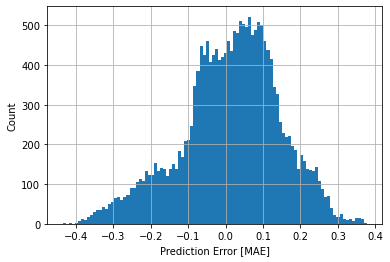

In [249]:
error = y_pred - y_test_u
plt.hist(error, bins = 100)
plt.xlabel("Prediction Error [MAE]")
plt.grid(True)

_ = plt.ylabel("Count")
plt.savefig("../figures/Xgboost_score_set_MAE.png",format="png")

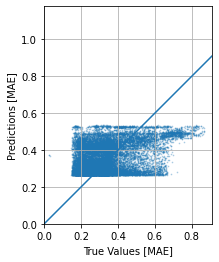

In [250]:
plt.scatter(y_test_u.compute(), y_pred.compute(),alpha=0.3,s=.5)
plt.grid(True)
plt.xlabel('True Values [MAE]')
plt.ylabel('Predictions [MAE]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.savefig("../figures/Xgboost_score_set_scatter_plot.png",format="png")

<BarContainer object of 157 artists>

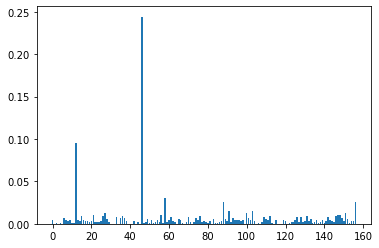

In [222]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)

In [223]:
df_T = pd.DataFrame(xgb.feature_importances_,X_train.drop(features,axis=1).columns)

In [224]:
df_T.sort_values(0,ascending=False,inplace=True)

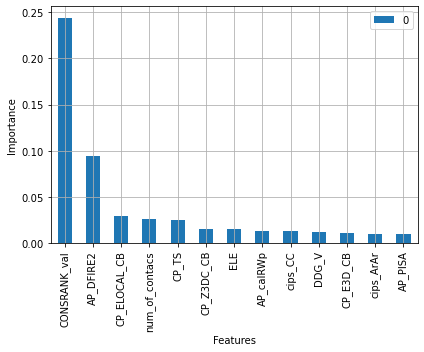

In [235]:
df_T[df_T[0]>0.01].plot(kind='bar',grid=True,figsize=(6,5))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig("../figures/xgboost_feature_selected.png",format="png")

In [226]:
y_pred= xgb.predict(X_val_u_fs.to_dask_array())
# cr = classification_report( y_true=y_val_u ,y_pred= y_pred.compute())
# print (cr )

In [227]:
regression_report( y_true=y_val_u ,y_pred= y_pred.compute(),name=x)


R^2: -7.3513390792646565
MAE: 0.2688435836267973
MSE: 0.07592563589771152


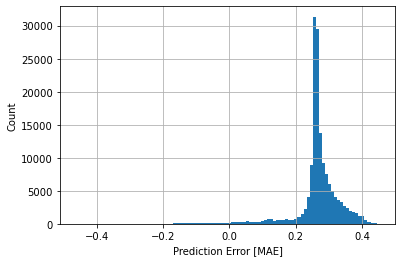

In [239]:
error = y_pred - y_val_u
plt.hist(error, bins = 100)
plt.xlabel("Prediction Error [MAE]")
plt.grid(True)
_ = plt.ylabel("Count")
plt.savefig("../figures/MAE_barplot_xgboost_base_model_validation.png",format="png")

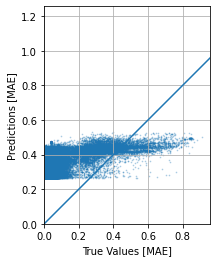

In [238]:
plt.scatter(y_val_u.compute(), y_pred.compute(),alpha=0.3,s=.5)
plt.xlabel('True Values [MAE]')
plt.ylabel('Predictions [MAE]')
plt.axis('equal')
plt.axis('square')
plt.grid(True)
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.savefig("../figures/MAE_xgboost_base_model_validation.png",format="png")


In [80]:
# params = {
#   'colsample_bynode': [0.2,0.4,0.6,0.8],
#   'learning_rate': [0.003,0.001,0.3,0.1,1],
#   'max_depth': [2,5,7,10],
#   'objective': ['binary:logistic','reg:squaredlogerror'],
#   'subsample': [0.2,0.4,0.6,0.8],
#   'tree_method': ['hist','approx'],
#     'booster':['dart','gbtree']
# }